In [12]:
import os
import random
import time
import glob
import json
import dit
import itertools
import time
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import gridspec
import seaborn as sns;sns.set()
import pandas as pd
from dit import Distribution
from scipy.optimize import minimize
from functools import partial

os.chdir("../")
from helpers.group_helpers import classify_syms, srv_to_mat
from helpers.compare_helpers import appendtoPXS,load_frame,addbestsym
from helpers.helpers import SeabornFig2Grid
from jointpdfpython3.measures import synergistic_entropy_upper_bound, append_random_srv
from jointpdfpython3.params_matrix import params2matrix_incremental,matrix2params_incremental
from jointpdfpython3.JointProbabilityMatrix import JointProbabilityMatrix
from jointpdfpython3.toy_functions import append_variables_with_target_mi
from syndisc.syndisc import self_disclosure_channel
os.chdir("./plot_notebooks")

## Convergence difference in WMS over number of steps

In [8]:
from scipy.optimize import minimize

class OpObj(object):
    def __init__(self, jXS,subjects,sid):
        self.jXS = jXS
        self.subjects=subjects
        self.sid=sid
        self.f = np.full(shape=(500,), fill_value=np.NaN)
        self.count = 0
    def _fun(self):
        totmi = self.jXS.mutual_information(self.subjects,[self.sid])
        indivmis = sum([self.jXS.mutual_information([i],[self.sid]) for i in self.subjects])        
        return totmi-indivmis
#         return self.jXS.synergistic_information_naive()
    
def cb(xk, obj=None):
    obj.f[obj.count] = obj._fun()
    obj.count += 1

def costf(srvparams,jXS,lenJXS,parX,subjects,upper):
    params2matrix_incremental(jXS,parX+list(srvparams))
    totmi = jXS.mutual_information(subjects,[lenJXS-1])
    indivmis = sum([jXS.mutual_information([i],[lenJXS-1]) for i in subjects])
    cost=abs((upper-(totmi-indivmis))/upper)
    if totmi != 0:
        return cost+((indivmis/totmi))
    else:
        return cost+(indivmis)

minimize_options = {'ftol': 1e-6}
def symsyninfo(states,lenX,jX,syms,initialtype='first',costf=costf):
    subjects = list(range(lenX))
    parX = matrix2params_incremental(jX)
    upper = synergistic_entropy_upper_bound(jX)
    jXS = append_random_srv(jX,parX,1)
    lenJXS = len(jXS)
    bestsymid=-1
    # get initial guess of best sym
    if initialtype!='random':
        if initialtype=='first':
            syms=[syms[0]]
        pXSym,bestsymid = addbestsym(lenX,jX,upper,syms)
        jXS.joint_probabilities.joint_probabilities = pXSym

    freeparams = (states**(lenJXS))-(states**(len(jX)))
    symparams = matrix2params_incremental(jXS)[-freeparams:]
    subjects = np.arange(lenX)
    op_obj = OpObj(jXS,subjects,lenJXS-1)
    optres_ix = minimize(costf,
                            symparams,
                            bounds=[(0.0, 1.0)]*freeparams,
                            callback=partial(cb,obj=op_obj),
                            args=(jXS,lenJXS,parX,subjects,upper),options=minimize_options)
    params2matrix_incremental(jXS,parX+list(optres_ix.x))
    return bestsymid,jXS, op_obj

In [9]:
x=np.linspace(1,500,500)
states = 2
lenX = 2
subjects = np.arange(lenX)
t='random'
cursyms = []
data = {'systemID':[],'repeats':[],'WMS(X;S)':[],'upper':[],'difference WMS':[],'Golden Mean':[],'difference GM':[]}
samples = 25
repeats = 7
for sys in range(samples):
    print("SYS ID",sys,datetime.fromtimestamp(time.time()))
    jXS = JointProbabilityMatrix(lenX+1,states)
    lenJXS = len(jXS)
    upper = synergistic_entropy_upper_bound(jXS[subjects])
    parXS = matrix2params_incremental(jXS)
    parX = parXS[:(states**lenX)-1]
    freeparams = len(parXS[(states**lenX)-1:])
    bestWMS = 0
    bestGM = 0
    for test in range(1,repeats+1):
        opts = []
        costs = []
        for _ in range(test):
            parS = np.random.random(freeparams)
            optres_ix = minimize(costf,
                                    parS,
                                    bounds=[(0.0, 1.0)]*freeparams,
                                    args=(jXS,lenJXS,parX,subjects,upper),options=minimize_options)
            opts.append(optres_ix.x)
            costs.append(optres_ix.fun)
        opt = opts[costs.index(min(costs))]
        params2matrix_incremental(jXS,parX+list(opt))
        totmi = jXS.mutual_information(subjects,[lenJXS-1])
        indivmis = [jXS.mutual_information([i],[lenJXS-1]) for i in subjects]
        data['systemID'].append(sys)
        data['repeats'].append(test)
        data['WMS(X;S)'].append(totmi-sum(indivmis))
        data['Golden Mean'].append(((totmi-sum(indivmis))+(totmi-max(indivmis)))/2)
        data['upper'].append(upper)
        
        if test == 1:
            bestWMS = data['WMS(X;S)'][-1]
            bestGM = data['Golden Mean'][-1]
            data['difference WMS'].append(0)
            data['difference GM'].append(0)
        else:
            data['difference WMS'].append(data['WMS(X;S)'][-1]-bestWMS)
            data['difference GM'].append(data['Golden Mean'][-1]-bestGM)
            if data['WMS(X;S)'][-1] > bestWMS:
                bestWMS=data['WMS(X;S)'][-1]
            if data['Golden Mean'][-1] > bestGM:
                bestGM=data['Golden Mean'][-1]

df = pd.DataFrame(data=data)

SYS ID 0 2022-05-11 20:00:56.780742


C:\Users\enrik\Desktop\Mabomba\Studie\MasterCS\Thesis\code\jointpdfpython3\JointProbabilityMatrix.py:527: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item == 'all':


SYS ID 1 2022-05-11 20:01:01.494311
SYS ID 2 2022-05-11 20:01:05.775651
SYS ID 3 2022-05-11 20:01:11.846604
SYS ID 4 2022-05-11 20:01:16.167745
SYS ID 5 2022-05-11 20:01:21.634544
SYS ID 6 2022-05-11 20:01:26.154009
SYS ID 7 2022-05-11 20:01:33.229247
SYS ID 8 2022-05-11 20:01:37.610712
SYS ID 9 2022-05-11 20:01:45.499640
SYS ID 10 2022-05-11 20:01:51.505877
SYS ID 11 2022-05-11 20:02:01.026398
SYS ID 12 2022-05-11 20:02:07.113297
SYS ID 13 2022-05-11 20:02:13.034005
SYS ID 14 2022-05-11 20:02:18.222642
SYS ID 15 2022-05-11 20:02:26.391052
SYS ID 16 2022-05-11 20:02:30.672936
SYS ID 17 2022-05-11 20:02:35.458623
SYS ID 18 2022-05-11 20:02:44.322228
SYS ID 19 2022-05-11 20:02:53.289450
SYS ID 20 2022-05-11 20:03:03.866159
SYS ID 21 2022-05-11 20:03:11.579595
SYS ID 22 2022-05-11 20:03:20.605948
SYS ID 23 2022-05-11 20:03:24.445719
SYS ID 24 2022-05-11 20:03:36.691367


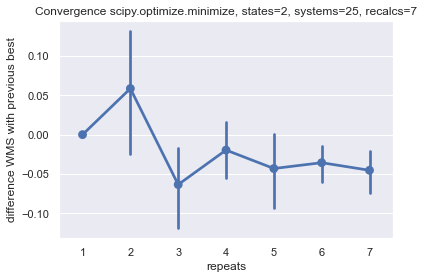

In [23]:
# df.to_pickle("../../results/test/optimalityjointpdfstates"+str(states)+".pkl")
df = pd.read_pickle("../../results/test/optimalityjointpdfstates"+str(3)+".pkl")
fig, ax = plt.subplots(1,1)
ax=sns.pointplot(data=df,x='repeats',y='difference WMS',ci=95)
plt.ylabel("difference WMS with previous best")
plt.title("Convergence scipy.optimize.minimize, states="+str(states)+", systems="+str(samples)+", recalcs="+str(repeats))
plt.show()

## Scipy optimize to find distribution with exact H(X1),H(X2),I(X1;X2) values

In [13]:
def costparams(srvparams,jXS,maxent,relent,relmi):
    params2matrix_incremental(jXS,srvparams)
#     mi = jXS.mutual_information([0],[1])
    ent1 = jXS.entropy([0])
    ent2 = jXS.entropy([1])
#     maxmi = max(ent1,ent2)
    return abs(relent-(ent1/maxent))+abs(relent-(ent2/maxent))
#     return (abs(relent-(ent1/maxent))/relent)+(abs(relent-(ent2/maxent))/relent)+(abs(relmi-(mi/maxmi))/relmi)


In [ ]:
sts = [2,3,4]
lenX = 2
relents = [0.3,0.5,0.7,0.9]
minimize_options = {'ftol': 1e-6}
samples=100
relmi = None
for s in sts:
    for j,relent in enumerate(relents):
        data = {'states':[],'parX':[],'relent':[],'maxent':[],'relmi':[],'mi':[]}
        jX = JointProbabilityMatrix(lenX,s,joint_probs='iid')
        lenpars = len(matrix2params_incremental(jX))
        maxent = jX.entropy([0])
        for i in range(samples):
#             data = {'states':[],'parX':[],'relent':[],'maxent':[],'relmi':[],'mi':[]}
            ent1=0
            ent2=0
            mi=0
            maxmi=1
            try:
                while abs(relent-(ent1/maxent))+abs(relent-(ent2/maxent))>0.1:
                    opts = []
                    costs = []
                    for tries in range(50):
                        if tries % 25 == 0:
                            print(tries,datetime.fromtimestamp(time.time()))
                        parX = np.random.random(lenpars)
                        optres_ix = minimize(costparams,
                                                    parX,
                                                    bounds=[(0.0, 1.0)]*len(parX),
                                                    args=(jX,maxent,relent,relmi),
                                                    options=minimize_options)
                        opts.append(optres_ix.x)
                        costs.append(optres_ix.fun)
                    opt = opts[costs.index(min(costs))]
                    params2matrix_incremental(jX,opt)
                    mi = jX.mutual_information([0],[1])
                    ent1 = jX.entropy([0])
                    ent2 = jX.entropy([1])
                    maxmi=max(ent1,ent2)
                print(i,ent1,ent2,mi)
                data['states'].append(s)
                data['parX'].append(opt)
                data['relent'].append(relent)
                data['maxent'].append(maxent)
                data['relmi'].append(relmi)
                data['mi'].append(mi)
#                 df = pd.DataFrame(data=data)
#                 df.to_pickle("../../results/test/scipyparxstates"+str(s)+"-"+str(j)+"-"+str(i)+".pkl")
            except:
                opt = None
                print("ERROR")
        df = pd.DataFrame(data=data)
        df.to_pickle("../../results/test/scipyparxstates"+str(s)+"-"+str(j)+"-"+str(i)+".pkl")


0 2022-05-14 19:45:12.923326


In [3]:
dist_type = 'scipyparx'
ds = []
folder = '../../results/test/'
os.chdir(folder)
allfiles = glob.glob("*.pkl")
files = [file for file in allfiles if dist_type in file]
if len(files) != 0:
    cur = []
    for f in files:
        cur.append(pd.read_pickle(f))
os.chdir('../../code/plot_notebooks')
d = pd.concat(cur)

def synsyns(row):
    jX = JointProbabilityMatrix(2,row['states'],joint_probs='iid')
    params2matrix_incremental(jX, row['parX'])
    row['H(X0)'] = jX.entropy([0])
    row['H(X1)'] = jX.entropy([1]) 
    row['I(X0;X1)'] = jX.mutual_information([0],[1])
    row['I(X0;X1) level'] = row['I(X0;X1)']/max(row['H(X0)'],row['H(X1)'])
    row['syn_upper']=synergistic_entropy_upper_bound(jX)
    pX = jX.joint_probabilities.joint_probabilities
    ditd = dit.Distribution.from_ndarray(pX)    
    try:
        row['syndisc_syn'] = self_disclosure_channel(ditd)[0]
        if row['syn_upper']>0:
            row['syndisc_normsyn'] = row['syndisc_syn']/row['syn_upper']
        else:
            row['syndisc_normsyn'] = row['syndisc_syn']
    except:
        print("ERROR")
    return row

data = d.apply(lambda row:synsyns(row),axis=1)
data['H(X0) level'] = data['H(X0)']/data['maxent']
data['H(X1) level'] = data['H(X1)']/data['maxent']
# data = data.dropna()
data.to_pickle('../../results/test/sameentmultiplemistates'+str(234)+'.pkl')


ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


## plot and load

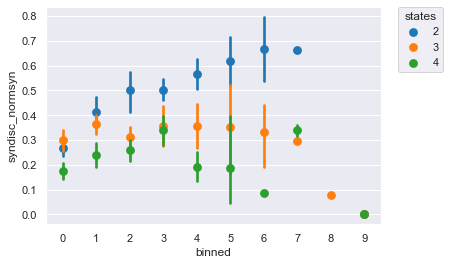

In [10]:
df = pd.read_pickle('../../results/test/sameentmultiplemistates'+str(234)+'.pkl')
bins = np.linspace(0,1,11)
labels = np.arange(10)
df['binned'] = pd.cut(df['I(X0;X1) level'], bins=bins, labels=labels)

hue='states'
sns.pointplot(data=df,x='binned',y='syndisc_normsyn',hue=hue,palette='tab10',join=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.01,title=hue)
plt.show()

# sns.pointplot(data=df,x='relent',y='syndisc_normsyn',hue=hue,palette='viridis')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.01,title=hue)

## Given H(X1)=max, compute syn info for different I(X1;X2) levels and states=[2,3,4]

In [3]:
statess = [2,3,4]
lenX = 1
allinputs = {}
unients = []
for states in statess:
    if states == 2:
        middle = [0.5]
    elif states==3:
        middle = [1/3,0.5]
    else:
        middle = [1/4,1/3,1/2]

    steps = 5
    inputs = np.linspace(np.zeros(len(middle))+0.1,middle,steps)
    allinputs[states]=[inputs[-1]]
    jX = JointProbabilityMatrix(lenX,states,joint_probs='iid')
    unient = jX.entropy([0])
    unients.append(unient)  

In [4]:
data={'H(X1)':[],'I(X1;X2)':[],'H(X1) level':[],'I(X1;X2) level':[],\
      'pX':[],'syn_upper':[],'states':[]}
repeats=25
for s in statess:
    inps = allinputs[s]
    mi_levels = np.linspace(0.1,0.9,9)
    jX = JointProbabilityMatrix(lenX,s)
    jpbs = []
    for ix,i in enumerate(inps):
        print(i,datetime.fromtimestamp(time.time()))
        params2matrix_incremental(jX,i)
        curent = jX.entropy()
        for mi in mi_levels:
            for _ in range(repeats):
                curjX = jX.copy()
                append_variables_with_target_mi(curjX,1,curent*mi)
                jpbs.append(curjX)
                data['H(X1) level'].append(curent/unients[s-2])
                data['I(X1;X2) level'].append(mi)
                data['H(X1)'].append(curent)
                data['I(X1;X2)'].append(curjX.mutual_information([0],[1]))
                data['states'].append(s)
                data['pX'].append(curjX.joint_probabilities.joint_probabilities)
                data['syn_upper'].append(synergistic_entropy_upper_bound(curjX))
data = pd.DataFrame(data=data)
data.to_pickle('../../results/test/testlevel.pkl')

[0.5] 2022-05-10 17:29:32.878410
[0.33333333 0.5       ] 2022-05-10 17:30:27.934180
[0.25       0.33333333 0.5       ] 2022-05-10 17:33:05.909409


In [5]:
data = pd.read_pickle('../../results/test/testlevel.pkl')

def syndiscsyns(row):
    ditd = dit.Distribution.from_ndarray(row['pX'])    
    
    try:
        row['syndisc_syn'] = self_disclosure_channel(ditd)[0]
        if row['syn_upper']>0:
            row['syndisc_normsyn'] = row['syndisc_syn']/row['syn_upper']
        else:
            row['syndisc_normsyn'] = row['syndisc_syn']
    except:
        print("ERROR")
    return row

data = data.apply(lambda row:syndiscsyns(row),axis=1)
data = data.dropna()
data.to_pickle('../../results/test/testlevel.pkl')

ERROR
ERROR
ERROR
ERROR


(-0.10000000000021017, 0.9937173346925056)

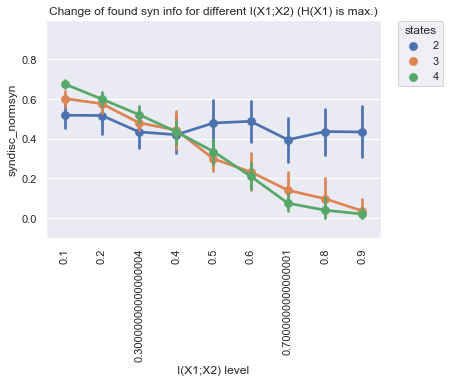

In [6]:
data = pd.read_pickle('../../results/test/testlevel.pkl')

plot = data[data['H(X1) level']==1]
plot=data
hue = 'states'
sns.pointplot(data=plot,x='I(X1;X2) level',y='syndisc_normsyn',hue=hue)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.01,title=hue)
plt.title("Change of found syn info for different I(X1;X2) (H(X1) is max.)")
plt.xticks(rotation=90)
plt.ylim(plot['syndisc_normsyn'].min()-0.1,plot['syndisc_normsyn'].max())